<h1><center>Water Quality</center></h1>

<h2>Packages</h2>

In [1]:
# Load packages such as ggplot2, dplyr, tidyr, and readr to be able to use specialised functions for creating
# visualisations, reading, writing, and manipulating data.
library(tidyverse)

-- Attaching packages --------------------------------------------------------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.8     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
-- Conflicts ------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [2]:
# Load the tidygeocoder package to be able to use a function to convert the given latitude and longitude
# to address.
library(tidygeocoder)

In [4]:
# Load skimr package to be able to use a function to understand the structure of the dataframe we will analyse
library(skimr)

In [5]:
# Load the knitr package to be able to use a function for presenting information in a tidy format.
library(knitr)

In [6]:
# Load the visdat package to be able to use a function for visualisation of the data. 
library(visdat)

In [7]:
# Load the lubridate package to be able to use function(s) for manipulating datetime data type.
library(lubridate)


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [8]:
# Load the highcharter package to be able to use interactive charting/graphing functions.
library(highcharter)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [9]:
library(jsonlite)
library(XML)
library(xml2)
library(glue)
library(httr)


Attaching package: 'jsonlite'


The following object is masked from 'package:purrr':

    flatten




<h2>Accessing and Importing Datasets</h2>

In [10]:
# A function to get data from the Ministry for the Environment database API

get_data_from_mfe <- function(api_key, data_id){
    
    query <- glue('https://data.mfe.govt.nz/services;key={api_key}/wfs?service=WFS&version=2.0.0&request=GetFeature&typeNames={data_id}') # creates a query url using inputs of api key and data-id number available on MfE website
    
    api_response <- GET(query) #gets the API response from the query
    
    data_xml <- read_xml(api_response) #reads the xml data from the api response
    
    data_parsed <- xmlParse(data_xml) #parses the data into an xml format that is readable in R
    
    data_df <- glue('//data.mfe.govt.nz:{data_id}') %>%  # creating a node name to look for
    getNodeSet(data_parsed, .)  %>%  # looking at nodes with the name
    xmlToDataFrame(nodes = .) #turns the data within the given node into a data frame
    
    return(data_df) #returns the data frame
}

In [11]:
# Get the river quality E. coli dataset from MfE using their API service.
# Then display the first six rows.
river_ecoli <- get_data_from_mfe("e046a540d83e49248cbda9cce3f23c2e", "table-109662")
river_ecoli %>% 
    head()

,field_1,measure_ab,measure,units,sof,nzsegment,lat,long,s_id,n_obs,...,sen_lci,sen_uci,analysis_note,percent_annual_change,trend_direction,seasonal,freq,period,end_year,trend_confidence
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,ECOLI,E. coli,cfu/100ml,WWL,5122005,-38.4616,177.8767,GDC-00027,54,...,-70.66574688,4.753992744,ok,-5.500677702,Improving,FALSE,BiMonth,NA,2000,Very likely improving
2,2,ECOLI,E. coli,cfu/100ml,CWH,4084132,-38.0824,176.2122,EBOP-00010,38,...,6.241040718,38.83610442,ok,9.98312095,Worsening,FALSE,Qtr,NA,2000,Very likely worsening
3,3,ECOLI,E. coli,cfu/100ml,WWL,4085815,-38.0795,177.1362,EBOP-00011,38,...,-23.56314936,90.18457384,ok,2.746276512,Worsening,TRUE,Qtr,NA,2000,Likely worsening
4,4,ECOLI,E. coli,cfu/100ml,CWLk,4081484,-38.044,176.3308,EBOP-00012,38,...,0,0.809965979,ok,6.646951774,Worsening,TRUE,Qtr,NA,2000,Very likely worsening
5,5,ECOLI,E. coli,cfu/100ml,CWH,4083343,-38.0465,176.988,EBOP-00042,38,...,0.587990625,10.7212543,ok,10.00919766,Worsening,TRUE,Qtr,NA,2000,Very likely worsening
6,6,ECOLI,E. coli,cfu/100ml,WXL,5063036,-37.6746,178.3481,GDC-00002,36,...,-7.598926487,6.825007124,WARNING: Sen slope based on tied non-censored values,0,Indeterminate,FALSE,Qtr,NA,2000,Indeterminate


In [12]:
# Get the river quality nitrogen dataset from MfE using their API service.
# Then display the first six rows.
river_nitrogen <- get_data_from_mfe("e046a540d83e49248cbda9cce3f23c2e", "table-109659")
river_nitrogen %>% 
    head()

,field_1,measure_ab,measure,units,sof,nzsegment,lat,long,s_id,n_obs,...,sen_lci,sen_uci,analysis_note,percent_annual_change,trend_direction,seasonal,freq,period,end_year,trend_confidence
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,NH4N,Ammoniacal nitrogen,g/m3,WWL,2038450,-36.8889,174.5221,ARC-00001,116,...,-0.000364871,0,WARNING: Sen slope influenced by censored values,0,Improving,FALSE,Month,NA,2000,Very likely improving
2,2,NH4N,Ammoniacal nitrogen,g/m3,WWL,2031444,-36.345,174.7118,ARC-00008,115,...,0,0.00079865,WARNING: Sen slope influenced by censored values,0,Worsening,FALSE,Month,NA,2000,Likely worsening
3,3,NH4N,Ammoniacal nitrogen,g/m3,WWL,2038644,-36.8949,174.5947,ARC-00013,118,...,0,0.001269986,ok,2.325248281,Worsening,FALSE,Month,NA,2000,Very likely worsening
4,4,NH4N,Ammoniacal nitrogen,g/m3,WDL,2040105,-36.9623,174.88,ARC-00015,108,...,-0.002164356,0.00166666,WARNING: Sen slope based on tied non-censored values,0,Indeterminate,FALSE,Month,NA,2000,Indeterminate
5,5,NH4N,Ammoniacal nitrogen,g/m3,WDL,2035880,-36.732,174.6947,ARC-00017,118,...,-0.009313005,-0.002790694,ok,-9.604112969,Improving,FALSE,Month,NA,2000,Very likely improving
6,6,NH4N,Ammoniacal nitrogen,g/m3,WWL,2033563,-36.551,174.6605,ARC-00026,117,...,-0.000242512,0.00157275,ok,1.727222315,Worsening,FALSE,Month,NA,2000,Likely worsening


In [52]:
# Read the groundwq.csv uploaded in GitHub and store it as groundwq for analysis.
groundwq <- "https://raw.githubusercontent.com/beuri97/data201_gp/waterq/water_quality/data/groundwq.csv" %>% 
  read_csv()
groundwq %>% 
    head()

Rows: 148645 Columns: 12
-- Column specification --------------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (8): Region, Agency, LAWASiteID, LAWAWellName, Indicator, Units, RawVal...
dbl  (3): Latitude, Longitude, CensoredValue
dttm (1): Date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Region,Agency,LAWASiteID,LAWAWellName,Latitude,Longitude,Indicator,Units,Date,RawValue,CenType,CensoredValue
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dttm>,<chr>,<chr>,<dbl>
Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.20052,174.8477,Chloride,g/m<U+00B3>,2012-05-01 08:48:00,28,not,28
Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.20052,174.8477,Chloride,g/m<U+00B3>,2012-07-20 11:07:00,27,not,27
Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.20052,174.8477,Chloride,g/m<U+00B3>,2012-10-09 11:56:00,27,not,27
Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.20052,174.8477,Chloride,g/m<U+00B3>,2013-01-09 10:55:00,27,not,27
Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.20052,174.8477,Chloride,g/m<U+00B3>,2013-04-16 12:02:00,29,not,29
Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.20052,174.8477,Chloride,g/m<U+00B3>,2014-04-24 11:35:00,27,not,27


<p style="text-align: justify"> We used the web and API services of the Ministry for the Environment to get the river quality datasets available in their database. However, the groundwater dataset in their database is incomplete. So instead, we downloaded the dataset available on the LAWA website and uploaded it on GitHub, then copied the link and used it to read the dataset in R. </p>

<h2>Conversion and Saving Data to CSV File</h2>

In [13]:
# Takes the available latitude and longitude information from the dataset then convert it to full address.
convert_lat_long <- function(df, lat, long){
    converted_df <- df %>%
    reverse_geocode(lat = lat, long = long, 
                    method = "osm", full_results = TRUE)
    return(converted_df)
}

In [14]:
## Takes the river_ecoli, and converts the provided latitudes and longitudes to add new columns containing the 
## address of the river sites. Then displays the first six rows.
# new_riverecoli <- convert_lat_long(river_ecoli, river_ecoli$lat, river_ecoli$long)
# new_riverecoli %>% head()

Passing 931 coordinates to the Nominatim single coordinate geocoder

Query completed in: 932.9 seconds



field_1,measure_ab,measure,units,sof,nzsegment,lat,long,s_id,n_obs,...,amenity,railway,neighbourhood,leisure,city_district,craft,historic,quarter,farm,shop
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ECOLI,E. coli,cfu/100ml,WWL,5122005,-38.4616,177.8767,GDC-00027,54,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,ECOLI,E. coli,cfu/100ml,CWH,4084132,-38.0824,176.2122,EBOP-00010,38,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,ECOLI,E. coli,cfu/100ml,WWL,4085815,-38.0795,177.1362,EBOP-00011,38,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,ECOLI,E. coli,cfu/100ml,CWLk,4081484,-38.044,176.3308,EBOP-00012,38,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,ECOLI,E. coli,cfu/100ml,CWH,4083343,-38.0465,176.988,EBOP-00042,38,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,ECOLI,E. coli,cfu/100ml,WXL,5063036,-37.6746,178.3481,GDC-00002,36,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [15]:
## Takes the river_nitrogen, and converts the provided latitudes and longitudes to add new columns containing the 
## address of the river sites. Then displays the first six rows.
# new_rivernitrogen <- convert_lat_long(river_nitrogen, river_nitrogen$lat, river_nitrogen$long)
# new_rivernitrogen %>% head()

Warning message in (function (lat, long, method = "osm", address = "address", limit = 1, :
"NAs introduced by coercion"
Warning message in (function (lat, long, method = "osm", address = "address", limit = 1, :
"NAs introduced by coercion"
Passing 944 coordinates to the Nominatim single coordinate geocoder

Query completed in: 946.1 seconds



field_1,measure_ab,measure,units,sof,nzsegment,lat,long,s_id,n_obs,...,neighbourhood,shop,building,farm,highway,railway,city_district,craft,quarter,historic
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,NH4N,Ammoniacal nitrogen,g/m3,WWL,2038450,-36.8889,174.5221,ARC-00001,116,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,NH4N,Ammoniacal nitrogen,g/m3,WWL,2031444,-36.345,174.7118,ARC-00008,115,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,NH4N,Ammoniacal nitrogen,g/m3,WWL,2038644,-36.8949,174.5947,ARC-00013,118,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,NH4N,Ammoniacal nitrogen,g/m3,WDL,2040105,-36.9623,174.88,ARC-00015,108,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,NH4N,Ammoniacal nitrogen,g/m3,WDL,2035880,-36.732,174.6947,ARC-00017,118,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,NH4N,Ammoniacal nitrogen,g/m3,WWL,2033563,-36.551,174.6605,ARC-00026,117,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [18]:
## Write the new dataset as CSVs for use.
# write_csv(new_riverecoli, "new_river_ecoli.csv")
# write_csv(new_rivernitrogen, "new_river_nitrogen.csv")

<p style="text-align: justify"> Region is one of the crucial variables in our dataset for relating datasets. Unfortunately, the river quality datasets we obtained from MfE only have the coordinates for the sites, so we decided to create a helper function using the `reverse_geocode` from `tidygeocoder` that takes latitude and longitude to find locations using geocoding methods. We then created new datasets containing the areas acquired from the conversion. We commented out the conversion and writing of new datasets, as the conversion process takes a lot of time, and we decided to use the links of the datasets we uploaded on GitHub. </p>

<h2>Groundwater Quality</h2>

In [53]:
# Gives an overview of groundwq such as columns, data types, the possible values, number of rows and columns.
groundwq %>% 
  glimpse()

Rows: 148,645
Columns: 12
$ Region        <chr> "Auckland", "Auckland", "Auckland", "Auckland", "Aucklan~
$ Agency        <chr> "Auckland Council", "Auckland Council", "Auckland Counci~
$ LAWASiteID    <chr> "LAWA-101648", "LAWA-101648", "LAWA-101648", "LAWA-10164~
$ LAWAWellName  <chr> "Patumahoe Springs", "Patumahoe Springs", "Patumahoe Spr~
$ Latitude      <dbl> -37.20052, -37.20052, -37.20052, -37.20052, -37.20052, -~
$ Longitude     <dbl> 174.8477, 174.8477, 174.8477, 174.8477, 174.8477, 174.84~
$ Indicator     <chr> "Chloride", "Chloride", "Chloride", "Chloride", "Chlorid~
$ Units         <chr> "g/m<U+00B3>", "g/m<U+00B3>", "g/m<U+00B3>", "g/m<U+00B3~
$ Date          <dttm> 2012-05-01 08:48:00, 2012-07-20 11:07:00, 2012-10-09 11~
$ RawValue      <chr> "28", "27", "27", "27", "29", "27", "28", "28", "28", "2~
$ CenType       <chr> "not", "not", "not", "not", "not", "not", "not", "not", ~
$ CensoredValue <dbl> 28, 27, 27, 27, 29, 27, 28, 28, 28, 28, 28, 27, 29, 28, ~


In [58]:
# Takes the groundwq modify the values and rename some columns, select the relevant columns 
# and rows to create a clean version of groundwq.
new_groundwq <- groundwq %>% 
  mutate(CensoredValue = ifelse(is.na(CensoredValue), NA_integer_, CensoredValue),
         Year = year(Date),
         Indicator = case_when(Indicator == "E.coli" ~ "E.coli cfu/100ml", TRUE ~ "Nitrate nitrogen g/m3"),
         Region = case_when(Region == "Hawkes Bay" ~ "Hawke's Bay",
                            Region == "Manawatu-Whanganui" ~ "Manawat??-Whanganui", TRUE ~ Region),
         WellName = LAWAWellName) %>% 
  select(Region, WellName, Latitude, Longitude, Indicator, Year, CensoredValue) %>% 
  filter(Indicator %in% c("E.coli cfu/100ml", "Nitrate nitrogen g/m3"), Year >= 2002, Year <= 2019)

In [63]:
# 
sites_quality <- new_groundwq %>% 
  select(Region, Year, WellName, CensoredValue, Indicator) %>% 
  group_by(Region, Year, WellName, Indicator) %>% 
  summarise(MeanVal = mean(CensoredValue)) %>% 
  filter(contains(Region, "Whanganui"))
sites_quality %>% 
    head()

`summarise()` has grouped output by 'Region', 'Year', 'WellName'. You can override using the `.groups` argument.


ERROR: [1m[33mError[39m in [1m[1m`filter()`:[22m
[1m[22m[33m![39m Problem while computing `..1 = contains(Region, "Whanganui")`.
[36mi[39m The error occurred in group 1: Region = "Auckland", Year = 2004, WellName = "BP Bombay".
[1mCaused by error:[22m
[33m![39m `contains()` must be used within a *selecting* function.
[34mi[39m See <https://tidyselect.r-lib.org/reference/faq-selection-context.html>.


In [50]:
sites <- new_groundwq %>% 
  select(Region, WellName, Latitude, Longitude) %>% 
  distinct

ERROR: Error in spread(., key = Indicator, value = Total_MedVal): object 'new_groundwq' not found


<h2>River Quality (E.coli)</h2>

In [32]:
# Load 'new_river_ecoli.csv' data
river_ecoli <- "https://raw.githubusercontent.com/beuri97/data201_gp/waterq/water_quality/data/new_river_ecoli.csv" %>% 
  read_csv()

Warning message:
"One or more parsing issues, see `problems()` for details"
Rows: 7550 Columns: 69
-- Column specification --------------------------------------------------------------------------------------------------------
Delimiter: ","
chr (40): measure_ab, measure, units, sof, s_id, analysis_note, trend_direct...
dbl (26): field_1, nzsegment, lat, long, n_obs, s, var_s, d, tau, z, p, c, c...
lgl  (3): seasonal, boundingbox, historic

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [51]:
# Gives an overview of river_ecoli such as columns, data types, the possible values, number of rows and columns.
river_ecoli %>% 
    glimpse()

Rows: 7,550
Columns: 69
$ field_1               <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1~
$ measure_ab            <chr> "ECOLI", "ECOLI", "ECOLI", "ECOLI", "ECOLI", "EC~
$ measure               <chr> "E. coli", "E. coli", "E. coli", "E. coli", "E. ~
$ units                 <chr> "cfu/100ml", "cfu/100ml", "cfu/100ml", "cfu/100m~
$ sof                   <chr> "WWL", "CWH", "WWL", "CWLk", "CWH", "WXL", "WWL"~
$ nzsegment             <dbl> 5122005, 4084132, 4085815, 4081484, 4083343, 506~
$ lat                   <dbl> -38.4616, -38.0824, -38.0795, -38.0440, -38.0465~
$ long                  <dbl> 177.8767, 176.2122, 177.1362, 176.3308, 176.9880~
$ s_id                  <chr> "GDC-00027", "EBOP-00010", "EBOP-00011", "EBOP-0~
$ n_obs                 <dbl> 54, 38, 38, 38, 38, 36, 36, 36, 37, 54, 55, 55, ~
$ s                     <dbl> -177, 172, 16, 45, 46, 0, 7, 7, -20, 369, 16, -1~
$ var_s                 <dbl> 17951.6667, 6324.0000, 434.0000, 420.3333, 432.0~
$ d             

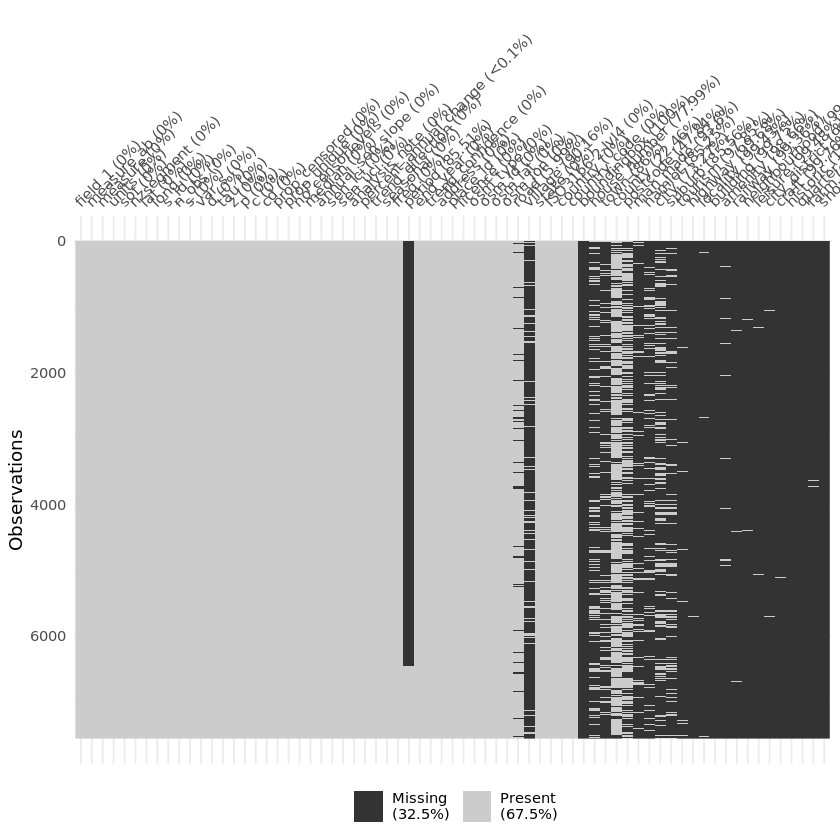

In [34]:
# Reads the entirety of river_ecoli and creates a plot to check if it contains missing data (NA).
river_ecoli %>% 
  vis_miss()

In [ ]:
# Select and rename the columns we need.
river_ecoli <- river_ecoli %>% 
  rename(Region = state, Year = end_year, Indicator = measure, Median = median, 
         Units = units) %>% 
  select(Region, Year, Indicator, Median, Units)

In [ ]:
# Check for missing data again (NA)
river_ecoli %>% 
  vis_miss()

In [ ]:
# Takes the river_ecoli group the rows by Region, Indicator, and Year then create an new data frame containing the 
# sum of the Median rounded off to 2.
new_riverecoli <- river_ecoli %>%
  filter(Year >= 2002, Year <= 2019) %>% 
  group_by(Region, Year, Indicator) %>% 
  summarise(Total_MedVal = round(sum(Median), 2)) %>% 
  unique()


In [ ]:
# Wide format data set spread by Indicator
riverecoli_wide <- new_riverecoli %>% 
  spread(key = Indicator,
         value = Total_MedVal) %>% 
  mutate(`E.coli (cfu/100ml)` = `E. coli`) %>% 
  select(-"E. coli")

<h2>River Quality (Nitrogen)</h2>

In [ ]:
# Read the new_river_nitrogen.csv and store it as river_nitrogen for analysis.
river_nitrogen <- "new_river_nitrogen.csv" %>% 
  read_csv()

In [ ]:
# Gives an overview of river_nitrogen such as columns, data types, the possible values, number of rows and columns.
# This allow us to select which relevant columns to select.
river_nitrogen %>% 
  glimpse()

In [ ]:
# Select the relevant columns for analysis.
river_nitrogen <- river_nitrogen %>% 
  select(measure, units, median, end_year, state)

In [ ]:
# Reads the entirety of river_nitrogen and creates a plot to check if it contains missing data (NA). 
river_nitrogen %>% 
  vis_miss()

In [ ]:
# Takes the river_nitrogen data frame then rename the columns, select the necessary rows, group them
# by Region, Indicator, and Year. Lastly, summarise them by getting the sum of the median values rounded
# off by 2 s.f.
new_rivernitrogen <- river_nitrogen %>% 
  rename(Region = state, Indicator = measure, Units = units, Med_Value = median,
         Year = end_year) %>% 
  filter(Indicator %in% c("Ammoniacal nitrogen", "Nitrate-nitrite nitrogen"),
         Year >= 2002, Year <= 2019) %>% 
  group_by(Region, Indicator, Year) %>% 
  summarise(Total_MedVal = round(sum(Med_Value), 2)) %>% 
  distinct()

In [ ]:
# Takes the new_rivernitrogen then convert it to wide format.
rivernitrogen_wide <- new_rivernitrogen %>% 
  spread(key = Indicator,
         value = Total_MedVal) %>% 
  mutate(`Ammoniacal nitrogen (g/m3)` = `Ammoniacal nitrogen`,
         `Nitrate-nitrite nitrogen (g/m3)` = `Nitrate-nitrite nitrogen`) %>% 
  select(-c(`Ammoniacal nitrogen`, `Nitrate-nitrite nitrogen`))
rivernitrogen_wide

<h2>Adding New Columns and Joining Dataframes</h2>

In [ ]:
# Join rivernitrogen_wide and riverecoli_wide to create river_quality dataframe.
river_quality <- rivernitrogen_wide %>% 
  full_join(riverecoli_wide)

In [ ]:
# Merge the tibble of categories with the existing groundwq and river_quality dataframes.
groundwq_categ <- tibble(Water_Categ = rep(c("Groundwater Quality"), each = nrow(new_groundwq)))
river_categ <- tibble(Water_Categ = rep(c("River Quality"), each = nrow(river_quality)))

groundwq <- cbind(new_groundwq, groundwq_categ)
river_quality <- cbind(river_quality, river_categ)

In [ ]:
# Join the groundwq and river_quality to create water quality dataframe.
# Normalise the indicator for all E.coli observation.
water_quality <- groundwq %>% 
  full_join(river_quality) %>% 
  mutate(Indicator = case_when(Indicator == "E. coli" ~ "E.coli", TRUE ~ Indicator))